In [157]:
import sys
import pickle
from pathlib import Path
gpu_implementation_path = '/home/mt/repos/research.mtne/gpu_implementation'
if gpu_implementation_path not in sys.path:
    sys.path.append(gpu_implementation_path)
import re
import numpy as np
import pandas as pd
import seaborn as sns
from esmt import TrainingState
import utils
import ijcnn_getters
import ijcnn_plots

# %matplotlib inline
%load_ext autoreload
%autoreload 2

main_log_dir = Path(gpu_implementation_path) / "logs"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
experiments = {
    'ST-zaxxon': {'dir': main_log_dir / 'ST-zaxxon-5000', 'type': 'ST'},
    'ST-riverraid': {'dir': main_log_dir / 'ST-riverraid-5000', 'type': 'ST'},
    'MT': {'dir': main_log_dir / 'MT-zaxxon-riverraid-5000', 'type': 'MT'},
    'MT50k': {'dir': main_log_dir / 'MT-zaxxon-riverraid-50000', 'type': 'MT'},
    'ST-riverraid-zaxxon': {'dir': main_log_dir / 'evaluate_riverraid_using_zaxxon_model', 'type': 'ST'},
    'ST-zaxxon-riverraid': {'dir': main_log_dir / 'evaluate_zaxxon_using_riverraid_model', 'type': 'ST'}
}
e = experiments
for exp_name, exp in experiments.items():
    exp['cfg'] = utils.get_config(exp)

In [177]:
for exp_name, exp in experiments.items():
    exp['rewards'] = ijcnn_getters.get_rewards(exp)

In [178]:
for exp_name, exp in experiments.items():
    exp['rewards_eplen'] = ijcnn_getters.get_rewards_eplen(exp)

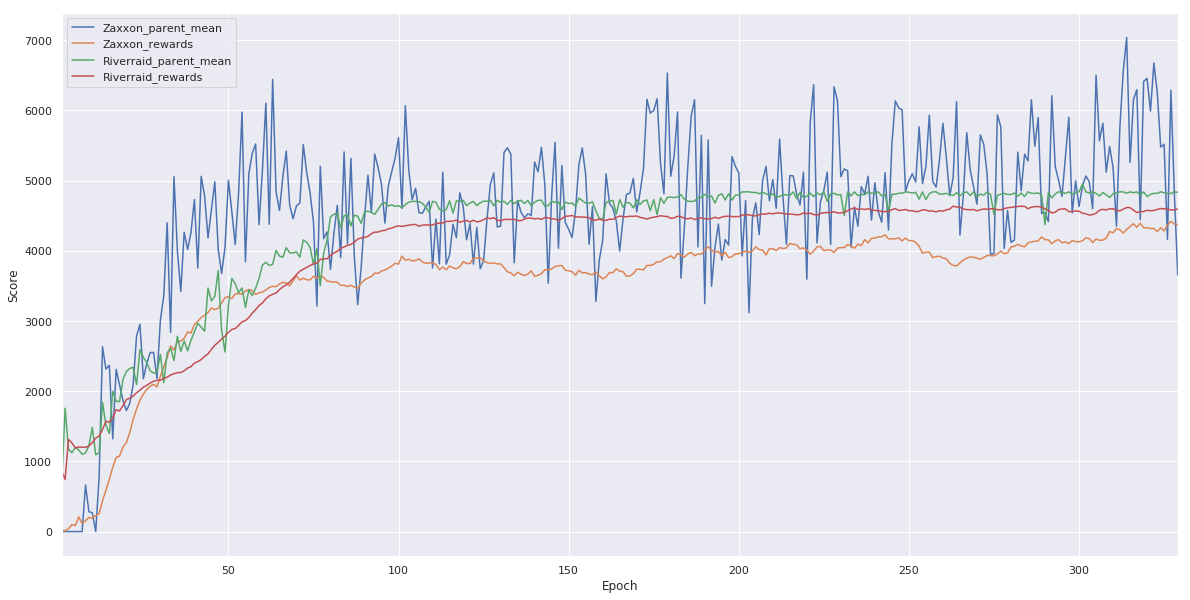

In [161]:
ijcnn_plots.rewards(e['MT'])

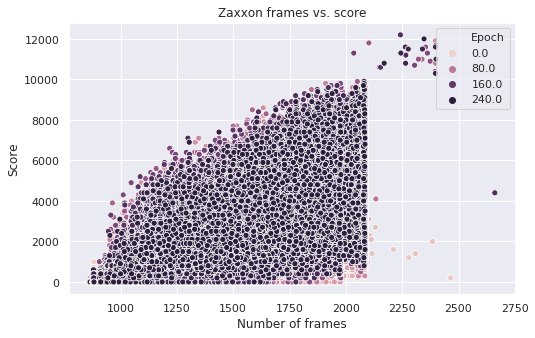

In [406]:
ijcnn_plots.frames_vs_score(e['MT'], 0, iterations=200)

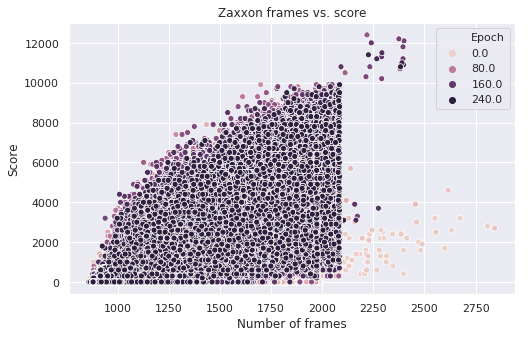

In [407]:
ijcnn_plots.frames_vs_score(e['MT50k'], 0, iterations=200)

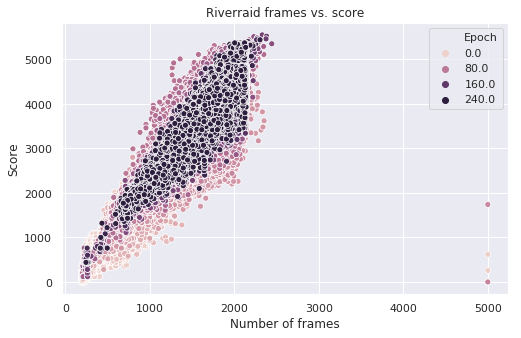

In [408]:
ijcnn_plots.frames_vs_score(e['MT'], 1, iterations=200)

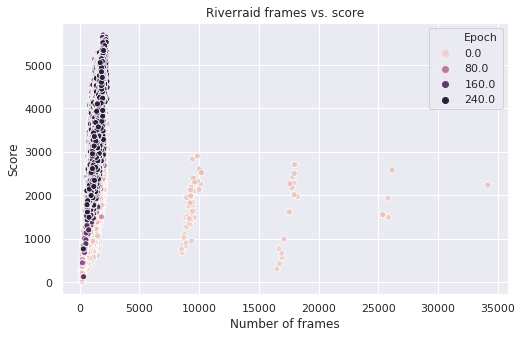

In [409]:
ijcnn_plots.frames_vs_score(e['MT50k'], 1, iterations=200)

In [164]:
# hypervolume: get data
hypervolume_experiments = {
    'MT': e['MT'],
    'ST-riverraid-zaxxon': e['ST-riverraid-zaxxon'],
    'ST-zaxxon-riverraid': e['ST-zaxxon-riverraid']
}
hv = ijcnn_getters.get_hypervolume(hypervolume_experiments, 200)
hv.columns = ['MTES: Zaxxon and Riverraid', 'Zaxxon weights evaluated on River Raid', 'River Raid weights evaluated on Zaxxon']

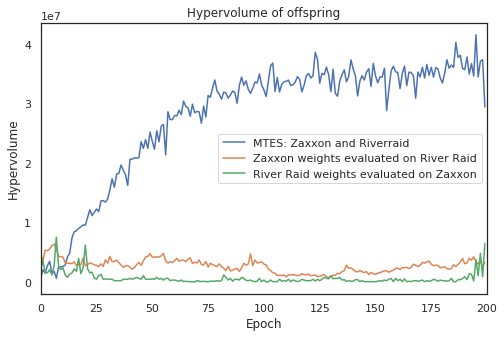

In [165]:
# hypervolume: plot
ijcnn_plots.hypervolume(hv)

In [ ]:
# dkl: get data
bin_size = 100
epsilon = 0.0001
iterations = 200
bin_sizes = [100, 250, 500, 1000]
iteration_lags = [-1, 1, 2, 10, 20, 50]
elite_or_parent = ['rewards', 'elite']
dkl_results = {}
for bsize in bin_sizes:
    for ilag in iteration_lags:
        for eop in elite_or_parent:
            result_key = str(bsize) + '__' + str(ilag) + '__' + eop
            print('Getting ' + result_key + ' ...')
            dkl_results[result_key] = pd.DataFrame.from_dict({
                'MT-zaxxon': [utils.compute_dkl(e['MT'], 0, i, bsize, epsilon, iteration_lag=ilag, elite_or_rewards=eop) for i in range(1, iterations)],
                'MT-riverraid': [utils.compute_dkl(e['MT'], 1, i, bsize, epsilon, iteration_lag=ilag, elite_or_rewards=eop) for i in range(1, iterations)]
            })

In [ ]:
for k, df in dkl_results.items():
    bin_size, ilag, er = k.split('__')
    ilag = int(ilag)
    fname = "dkl/{}__{}__{}.png".format(bin_size, ilag, er)
    print(bin_size, ilag, er)
    p = df.plot()
    p.set_title("MTES DKL: bin_size={}, iteration_lag={}, series={}".format(bin_size, ilag, er))
    p.set_xlabel("Epoch")
    p.set_ylabel("DKL")
    p.set_yscale('log')
    p.set_xscale('log')
    p.set_xlim([max(ilag, 0), 200])
    p.set_ylim([0, 10])
    fig = p.get_figure()
    fig.savefig(fname)

In [327]:
mt5k_outperf = ijcnn_getters.get_outerperformer_data(e['MT'], iterations=200)

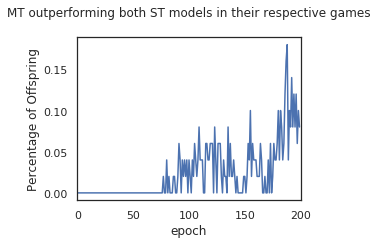

In [328]:
ijcnn_plots.outperformer(mt5k_outperf, iterations=200, title='MT outperforming both ST models in their respective games')

In [329]:
mt50k_outperf = ijcnn_getters.get_outerperformer_data(e['MT50k'], iterations=200)

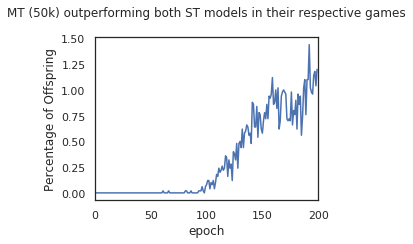

In [330]:
ijcnn_plots.outperformer(mt50k_outperf, iterations=200, title="MT (50k) outperforming both ST models in their respective games")

In [479]:
### E.5) other plots
# thresholds from https://arxiv.org/pdf/1703.03864.pdf

### 5k, Zaxxon and Riverraid
raw_offspring_zaxxon_5k = ijcnn_getters.get_raw_offspring(e['MT'], 0)
raw_offspring_zaxxon_5k.head()
# raw_offspring_zaxxon_5k_metrics = raw_offspring_zaxxon_5k.groupby(['epoch'])['Zaxxon_offspring'].agg([('min', np.min), ('mean', np.mean), ('max', np.max)])
# raw_offspring_zaxxon_5k_metrics['Epoch'] = raw_offspring_zaxxon_5k_metrics.index
# melted_raw_offspring_zaxxon_5k_metrics = pd.melt(raw_offspring_zaxxon_5k_metrics, id_vars=['Epoch'], value_name='Score')

# raw_parent_zaxxon_5k = ijcnn_getters.get_raw_parent(e['MT'], 0)
# raw_parent_zaxxon_5k_metrics = raw_parent_zaxxon_5k.groupby(['epoch'])['Zaxxon_parent'].agg([('min', np.min), ('mean', np.mean), ('max', np.max)])
# raw_parent_zaxxon_5k_metrics['Epoch'] = raw_parent_zaxxon_5k_metrics.index
# melted_raw_parent_zaxxon_5k_metrics = pd.melt(raw_parent_zaxxon_5k_metrics, id_vars=['Epoch'], value_name='Score')

# raw_offspring_riverraid_5k = ijcnn_getters.get_raw_offspring(e['MT'], 1)
# raw_offspring_riverraid_5k_metrics = raw_offspring_riverraid_5k.groupby(['epoch'])['Riverraid_offspring'].agg([('min', np.min), ('mean', np.mean), ('max', np.max)])
# raw_offspring_riverraid_5k_metrics['Epoch'] = raw_offspring_riverraid_5k_metrics.index
# melted_raw_offspring_riverraid_5k_metrics = pd.melt(raw_offspring_riverraid_5k_metrics, id_vars=['Epoch'], value_name='Score')

# raw_parent_riverraid_5k = ijcnn_getters.get_raw_parent(e['MT'], 1)
# raw_parent_riverraid_5k_metrics = raw_parent_riverraid_5k.groupby(['epoch'])['Riverraid_parent'].agg([('min', np.min), ('mean', np.mean), ('max', np.max)])
# raw_parent_riverraid_5k_metrics['Epoch'] = raw_parent_riverraid_5k_metrics.index
# melted_raw_parent_riverraid_5k_metrics = pd.melt(raw_parent_riverraid_5k_metrics, id_vars=['Epoch'], value_name='Score')

# ### 50k, Zaxxon and Riverraid
# raw_offspring_zaxxon_50k = ijcnn_getters.get_raw_offspring(e['MT50k'], 0)
# raw_offspring_zaxxon_50k_metrics = raw_offspring_zaxxon_50k.groupby(['epoch'])['Zaxxon_offspring'].agg([('min', np.min), ('mean', np.mean), ('max', np.max)])
# raw_offspring_zaxxon_50k_metrics['Epoch'] = raw_offspring_zaxxon_50k_metrics.index
# melted_raw_offspring_zaxxon_50k_metrics = pd.melt(raw_offspring_zaxxon_50k_metrics, id_vars=['Epoch'], value_name='Score')

# raw_parent_zaxxon_50k = ijcnn_getters.get_raw_parent(e['MT50k'], 0)
# raw_parent_zaxxon_50k_metrics = raw_parent_zaxxon_50k.groupby(['epoch'])['Zaxxon_parent'].agg([('min', np.min), ('mean', np.mean), ('max', np.max)])
# raw_parent_zaxxon_50k_metrics['Epoch'] = raw_parent_zaxxon_50k_metrics.index
# melted_raw_parent_zaxxon_50k_metrics = pd.melt(raw_parent_zaxxon_50k_metrics, id_vars=['Epoch'], value_name='Score')

# raw_offspring_riverraid_50k = ijcnn_getters.get_raw_offspring(e['MT50k'], 1)
# raw_offspring_riverraid_50k_metrics = raw_offspring_riverraid_50k.groupby(['epoch'])['Riverraid_offspring'].agg([('min', np.min), ('mean', np.mean), ('max', np.max)])
# raw_offspring_riverraid_50k_metrics['Epoch'] = raw_offspring_riverraid_50k_metrics.index
# melted_raw_offspring_riverraid_50k_metrics = pd.melt(raw_offspring_riverraid_50k_metrics, id_vars=['Epoch'], value_name='Score')

# raw_parent_riverraid_50k = ijcnn_getters.get_raw_parent(e['MT50k'], 1)
# raw_parent_riverraid_50k_metrics = raw_parent_riverraid_50k.groupby(['epoch'])['Riverraid_parent'].agg([('min', np.min), ('mean', np.mean), ('max', np.max)])
# raw_parent_riverraid_50k_metrics['Epoch'] = raw_parent_riverraid_50k_metrics.index
# melted_raw_parent_riverraid_50k_metrics = pd.melt(raw_parent_riverraid_50k_metrics, id_vars=['Epoch'], value_name='Score')


,epoch,Zaxxon_offspring
0,0,"[0.0, 0.0]"
1,0,"[0.0, 0.0]"
2,0,"[0.0, 0.0]"
3,0,"[0.0, 0.0]"
4,0,"[0.0, 0.0]"


In [482]:
raw_offspring_zaxxon_5k.tail(5)

,epoch,Zaxxon_offspring
2495,199,"[5900.0, 6500.0]"
2496,199,"[7600.0, 3000.0]"
2497,199,"[4600.0, 4700.0]"
2498,199,"[4400.0, 4800.0]"
2499,199,"[2400.0, 3600.0]"


Text(0.5, 1.0, 'MT (50k) Zaxxon parent')

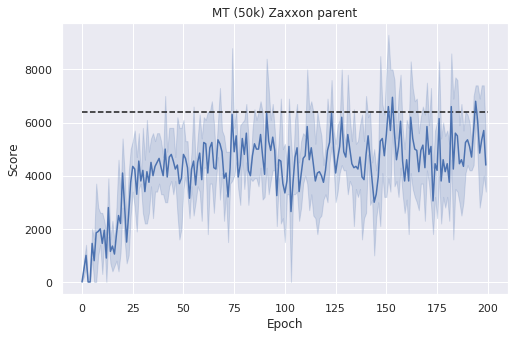

In [475]:
sns.set(rc={'figure.figsize':(8, 5)})
p = sns.lineplot(x='Epoch', y='Score', data=melted.query("variable in ['min', 'max']"))
p.hlines(6380, 0, iterations, linestyles='dashed') # draw threshold across 0:iterations
p.set_title('MT (50k) Zaxxon, parent')